# 0.0 IMPORTS
---

In [91]:
import json
import pickle
import pandas                                                 as pd
import seaborn                                                as sns
import xgboost                                                
import warnings                               
import requests 

from time                      import time
from boruta                    import BorutaPy
from datetime                  import datetime, timedelta
from matplotlib                import pyplot                  as plt
from IPython.core.display      import HTML

from sklearn.svm               import SVR
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing     import LabelEncoder, MinMaxScaler
from sklearn.model_selection   import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [121]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def save_parameter_encoder( encoder, param_name, label ):
    if label == 'label_encoder':
        keys = encoder.classes_
        values = encoder.transform( encoder.classes_ )
        param = dict( zip( keys, values ) )
        
    else: #label == 'minmax'
        param = {'min': mms.data_min_, 'max': mms.data_max_}
    
    pickle.dump( param, open( '/Users/meigarom/repos/Predictive-Analytics/parameter/param_{}.pkl'.format( param_name ), 'wb' ) )
    
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean( ( np.abs( y_true - y_pred ) / y_true ) )


def mean_percentage_error(y_true, y_pred): 
    return np.mean( ( y_true - y_pred ) / y_true )
    
    
def rmspe( y, yhat ):
    return np.sqrt( np.mean( ( yhat/y-1) **2 ) )


def rmspe_xg( yhat, y ):
    y = np.expm1( y.get_label() )
    yhat = np.expm1( yhat )
    return 'rmspe', rmspe( y, yhat )


def ml_error( model_name, y_test, yhat ):
    error = rmspe( y_test, yhat )
    mae = mean_absolute_error( y_test, yhat )
    mape = mean_absolute_percentage_error( y_test, yhat )
    rmse = np.sqrt( mean_squared_error( y_test, yhat ) )
    
    return pd.DataFrame( {'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse, 'RMSPE': error}, index=[0] )


def xgb_model( x_train, y_train, x_valid, y_valid, params ):
    dtrain = xgb.DMatrix( x_train, y_train )
    dvalid = xgb.DMatrix( x_valid, y_valid )
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    return xgb.train( params, dtrain, num_boost_round=6000, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=False )


def nested_cross_validation( training_start, training_end, holdout_end, kfold, X_train, model, verbose=0 ):
    # result list
    mae_list = []
    mape_list = []
    rmse_list = []
    rmspe_list = []
    
    # how many days between training end and holdout end
    n_day = np.round( ( holdout_end - training_end ).days / kfold )
    
    # K fold cross validation
    for i in range( 1, kfold + 1 ):
        if verbose == 1:
            print( 'Fold K: {}'.format( i ) )
        # trainn
        fold_training_start = training_start
        fold_training_end = training_end + timedelta( days=( i - 1 )*n_day )
        
        # valid
        fold_valid_start = fold_training_end
        fold_valid_end = training_end + timedelta( days=( i * n_day ) )
        
        # model training with k fold
        x_train = X_train[(X_train['date'] >= fold_training_start) & (X_train['date'] <= fold_training_end)]
        y_train = x_train['sales']
        x_train = x_train.drop( ['sales', 'date'], axis=1 )

        # valid fold k
        x_valid = X_train[(X_train['date'] > fold_valid_start) & (X_train['date'] <= fold_valid_end)]
        y_valid = x_valid['sales']
        x_valid = x_valid.drop( ['sales', 'date'], axis=1 )
        
        # modelling
        model_fitted = model.fit( x_train, y_train )
        
        # predictions
        yhat = model_fitted.predict( x_valid )
        
        # performance
        results = ml_error( 'model', np.expm1( y_valid ), np.expm1( yhat ) )
        
        mae_list.append( results['MAE'][0] )
        mape_list.append( results['MAPE'][0] )
        rmse_list.append( results['RMSE'][0] )
        rmspe_list.append( results['RMSPE'][0] )
    
        #print( lr_results )
        #print( '\n')
    
    return { 'AVG MAE': np.mean( mae_list ), 'STD MAE': np.std( mae_list ), 
             'AVG MAPE': np.mean( mape_list ), 'STD MAPE': np.std( mape_list ), 
             'AVG RMSE': np.mean( rmse_list ), 'STD RMSE': np.std( rmse_list ), 
             'AVG RMSPE': np.mean( rmspe_list ), 'STD RMSPE': np.std( rmspe_list )}

In [89]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv( '../data/train.csv' )
df_stores_raw = pd.read_csv( '../data/store.csv' )

# Merge dataset
df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

# 1.0. DATA PREPARATION
---

In [6]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
107406,367,7,2015-04-26,0,0,0,0,0,0,d,c,2640.0,9.0,2012.0,0,NaN,NaN,NaN
766326,1107,3,2013-08-14,6341,668,1,1,0,1,a,a,1400.0,6.0,2012.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 1.1. Rename Attributes

In [7]:
df1 = df_raw.copy()

In [8]:
# new columns name
new_cols=['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']

# rename
df1.columns = new_cols

In [9]:
df1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
684728,904,6,2013-10-26,5843,501,1,0,0,0,d,c,570.0,7.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
7316,627,6,2015-07-25,7732,687,1,0,0,0,c,c,3970.0,3.0,2010.0,0,NaN,NaN,NaN


# 2.0. DESCRIBE DATA
---

In [10]:
df2 = df1.copy()

## 2.1. Data Dimensions

In [11]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}'.format( df2.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 2.2. Data Type Attributes

In [12]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# convert to datetime
df2['date'] = pd.to_datetime( df2['date'] )

df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.3. Number of NA

In [14]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1014567 non-null float64
competition_open_since_month    693861 non-null float64
competition_open_since_year     693861 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               509178 non-nul

## 2.4. Treat NA columns

In [16]:
df2.sample( 2 )

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
800851,1067,7,2013-07-14,0,0,0,0,0,0,d,c,12020.0,7.0,2009.0,0,NaN,NaN,NaN
786321,1032,6,2013-07-27,4415,458,1,0,0,0,d,c,270.0,2.0,2013.0,1,40.0,2012.0,"Jan,Apr,Jul,Oct"


In [17]:
# promo2_since_year
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo2_since_week
df2['promo2_since_week'] = df2.apply( lambda x: x['date'].weekofyear if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# competition_distance
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

# competition_open_since_year
df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo_interval
## fill na with 0
df2.fillna( 0, inplace=True )
# if date is in the promo interval, there is promo.
monthmap = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df2['month_map'] = df2['date'].dt.month.map( monthmap )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [18]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5. Change the Columns Data Types

In [19]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
# change competition data - Month and Year
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )

# change competition data - Week
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

In [21]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.6. Descriptive statistics

In [22]:
# separate the categorical from numerical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df2.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 5
Num of Numerical: 14
Num of Date: 1


### 2.6.1. Central Tendency and Dispersion 

#### 2.6.1.1. Numerical Attributes

In [23]:
# Meausure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T


# Dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'kurtosis', 'skew']

m

,attributes,min,max,range,mean,median,standard_deviation,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


### 2.6.1.2. Categorical Attributes

In [24]:
c = pd.DataFrame( cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
print( c )

    Columns Names  Number of Levels
0   state_holiday                 5
1      store_type                 4
2      assortment                 3
3  promo_interval                 4
4       month_map                12


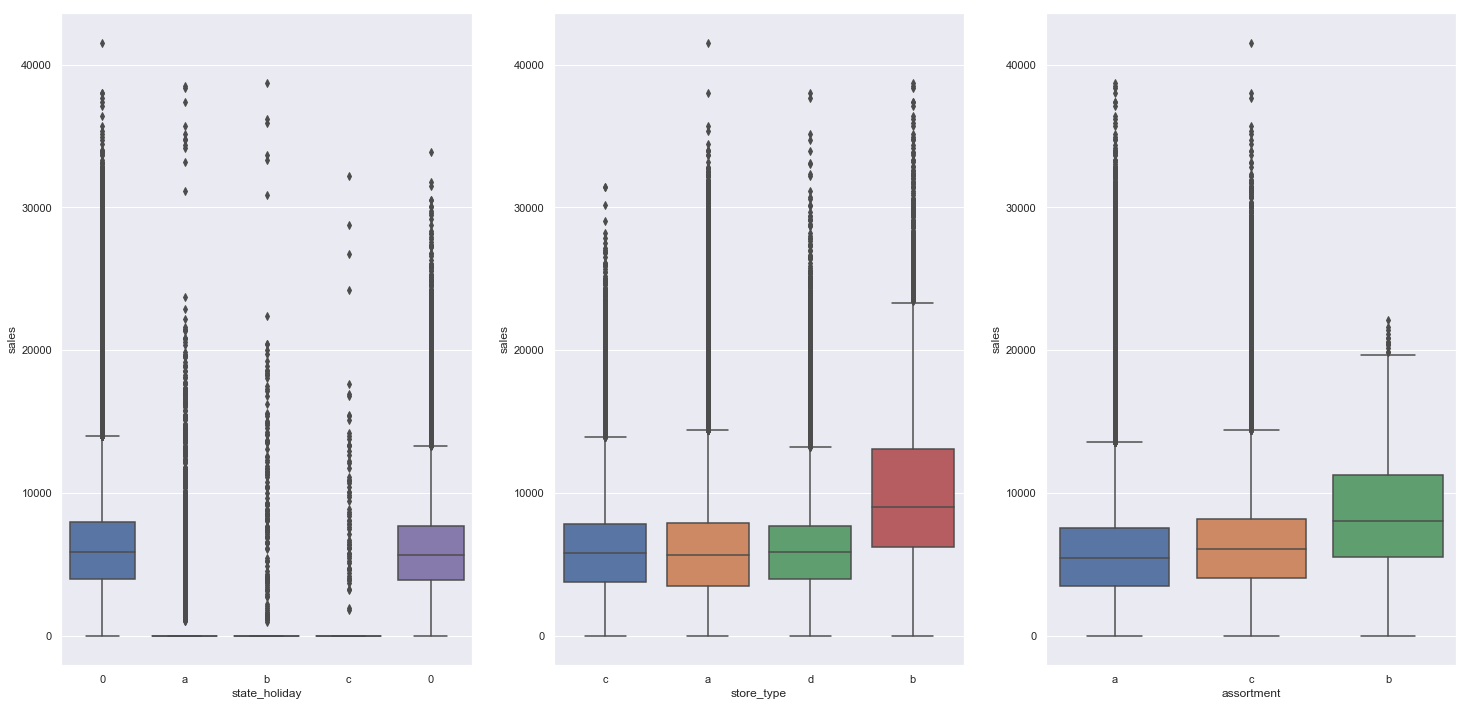

In [25]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df2 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df2 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df2 );

# 3.0. FEATURE ENGINEERING
---

In [26]:
df3 = df2.copy()

## 3.1. Feature Creation

In [27]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# state_holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# competition weeks
df3['month_of_competition'] = 12*( df3['year'] - df3['competition_open_since_year'] ) + ( df3['month'] - df3['competition_open_since_month'] )
df3['month_of_competition'] = df3['month_of_competition'].apply( lambda x: x if x > 0 else 0 )

# promomotion weeks
df3['month_of_promo'] = 12*( df3['year'] - df3['promo2_since_year'] ) + ( df3['week_of_year'] - df3['promo2_since_week'] )/4
df3['month_of_promo'] = df3['month_of_promo'].apply( lambda x: x if x > 0 else 0 )

# 4.0. SELECT FEATURES
---

In [28]:
df4 = df3.copy()

## 4.1. Filtering Rows

In [29]:
# only use data of Sales > 0 and Open is 1
df4 = df4[ (df4['open'] != 0) & (df4['sales'] > 0) ]

## 4.2. Selecting Columns

**Columns to Drop**
1. **date**: foram derivados novas features da variavel date
2. **customers**: voce nao sabe o numero de clientes no momento da predicao
3. **open**: todas as linhas sao open
4. **promo interval**: foram derivadas novas features
5. **month map**: variável auxiliar

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drop columns
df4 = df4.drop( cols_drop, axis=1 )

In [31]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25


# 5.0. EXPLORATION DATA ANALYSIS 
---

In [32]:
df5 = df4.copy()

In [33]:
# separate the categorical from numerical features
num_attributes = df5.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df5.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df5.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 3
Num of Numerical: 18
Num of Date: 1


## 5.1. Univariate Analysis

### 5.1.1. Response Variable

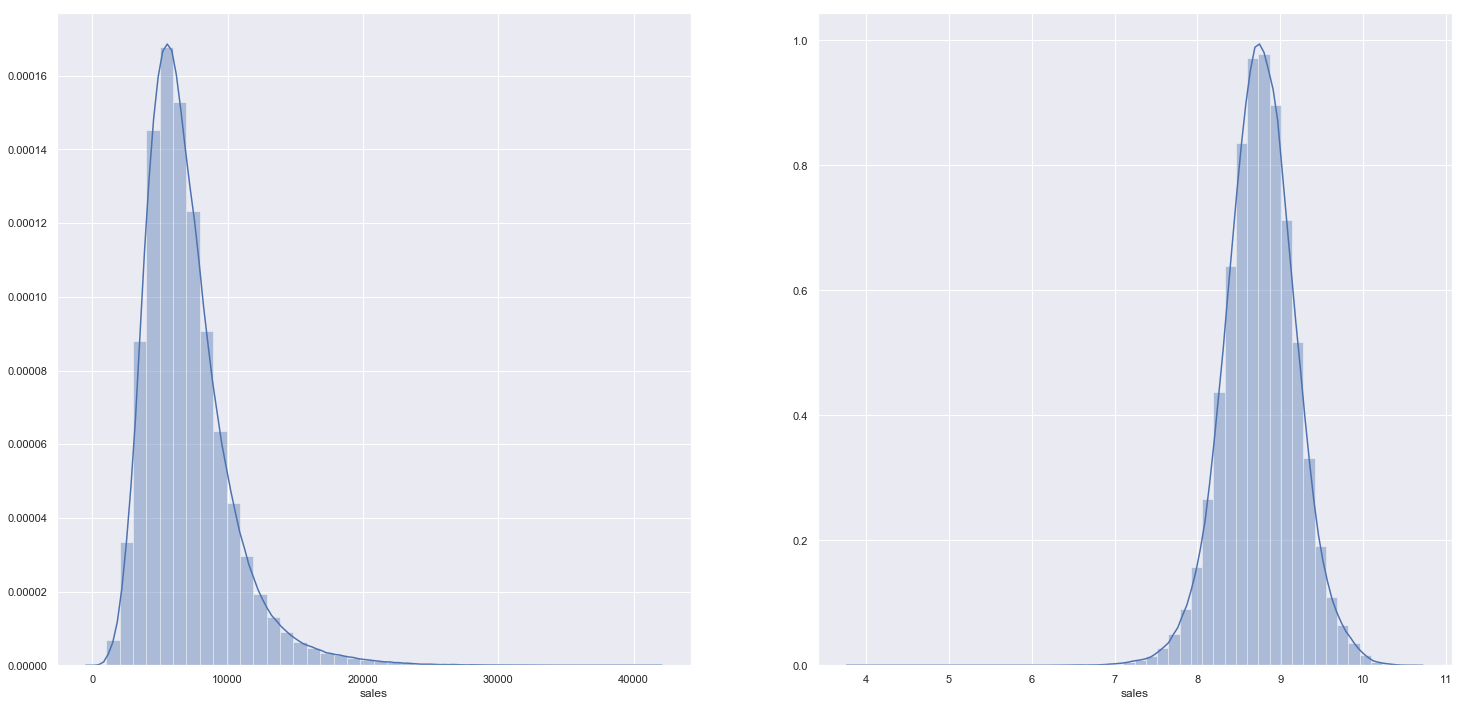

In [34]:
plt.subplot( 1, 2, 1 )
sns.distplot( df5['sales'], kde=True, bins=42 )

plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( df5['sales'] ), kde=True )

### 5.1.2. Numerical Predictors

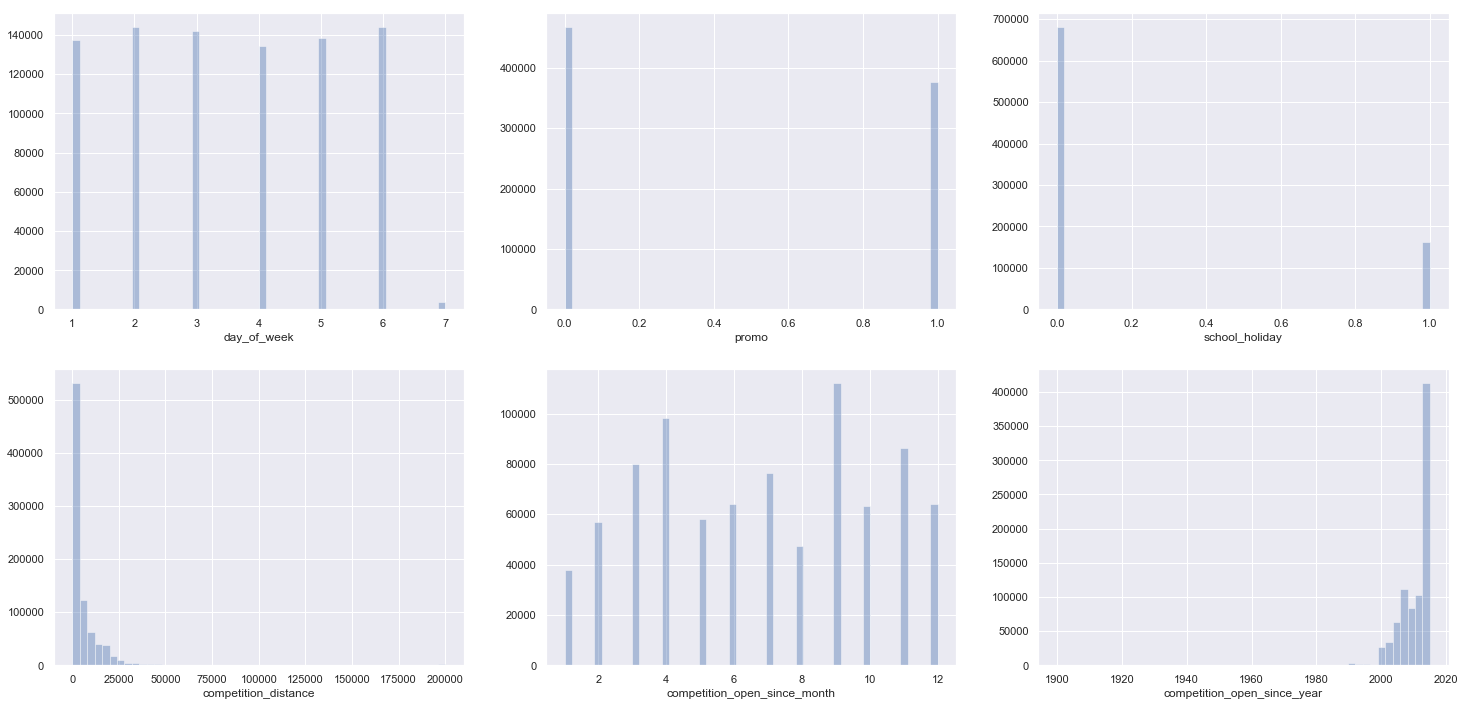

In [35]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['day_of_week'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['school_holiday'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['competition_distance'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['competition_open_since_month'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['competition_open_since_year'], kde=False );

In [36]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,70,0.00
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,3,0.00


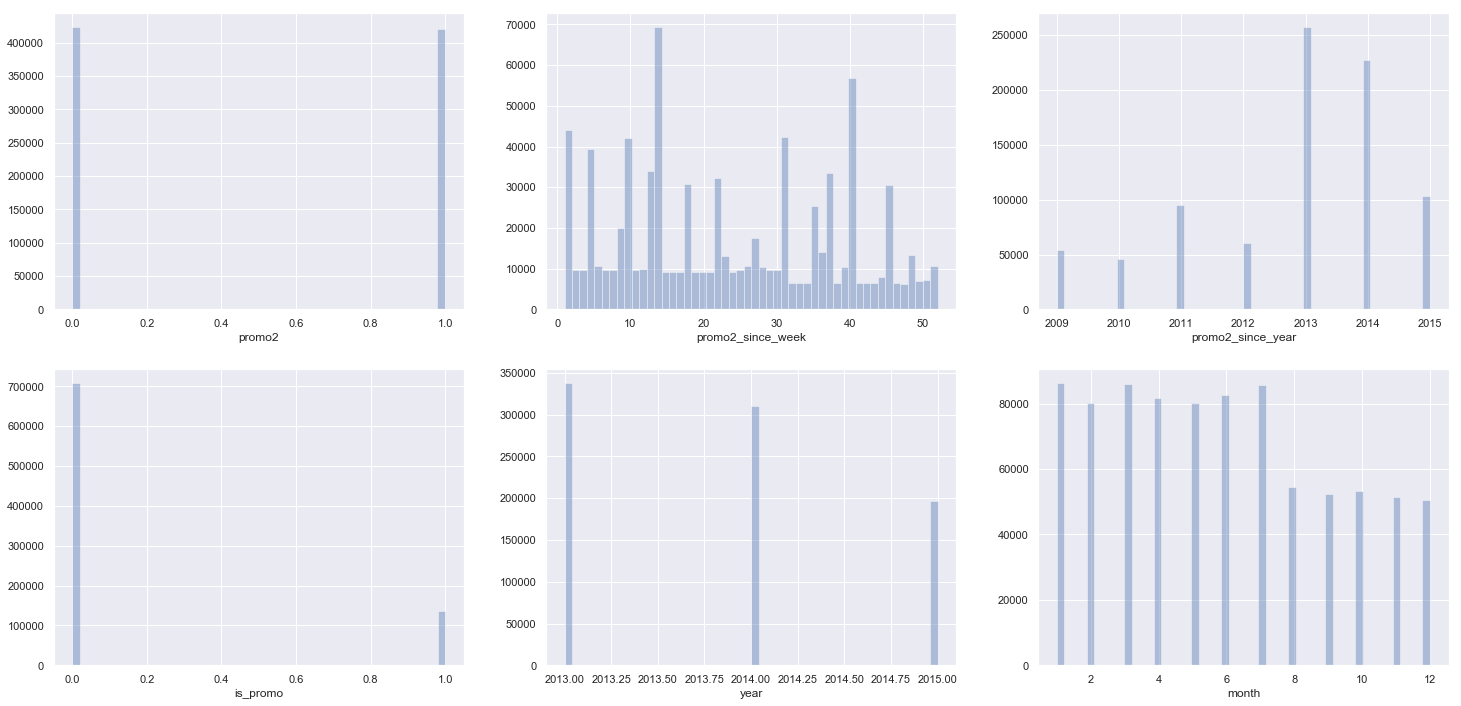

In [37]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['promo2'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo2_since_week'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['promo2_since_year'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['is_promo'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['year'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['month'], kde=False );

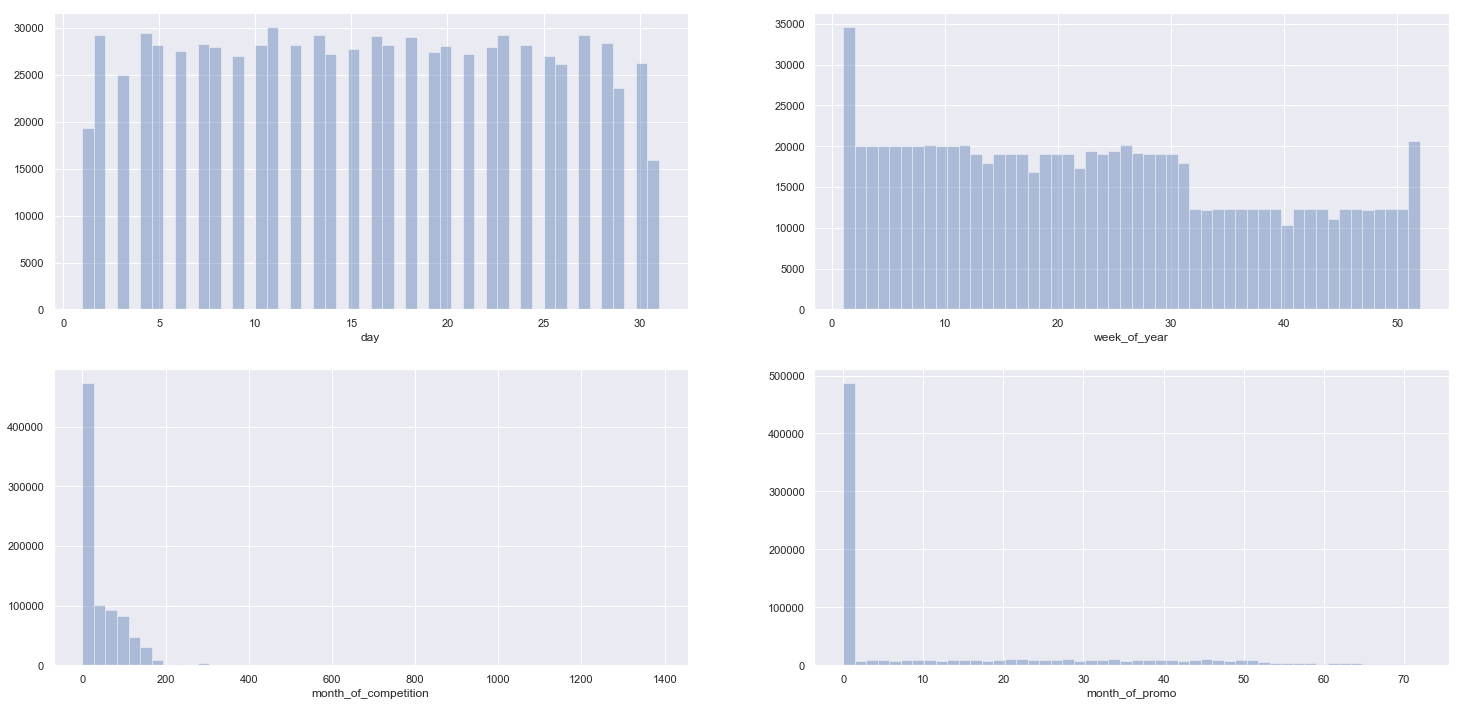

In [38]:
plt.subplot( 2, 2, 1 )
sns.distplot( df5['day'], kde=False );

plt.subplot( 2, 2, 2 )
sns.distplot( df5['week_of_year'], kde=False );

plt.subplot( 2, 2, 3 )
sns.distplot( df5['month_of_competition'], kde=False );

plt.subplot( 2, 2, 4 )
sns.distplot( df5['month_of_promo'], kde=False );

### 5.1.3. Categorical Predictors

In [39]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


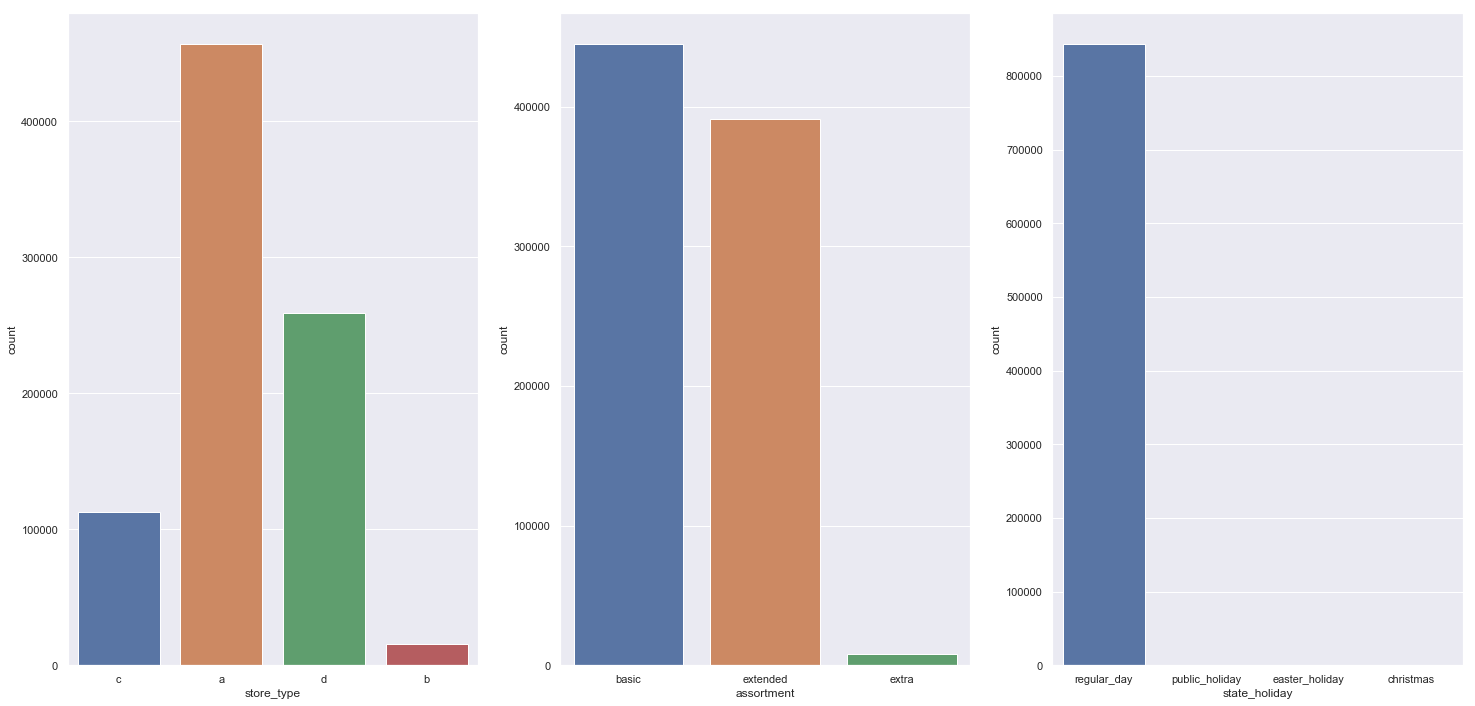

In [40]:
plt.subplot( 1, 3, 1 )
sns.countplot( x='store_type', data=df5 )

plt.subplot( 1, 3, 2 )
sns.countplot( x='assortment', data=df5 )

plt.subplot( 1, 3, 3 )
sns.countplot( x='state_holiday', data=df5 )

## 5.2. Bivariate Analysis

### 5.2.1. Numerical Predictors

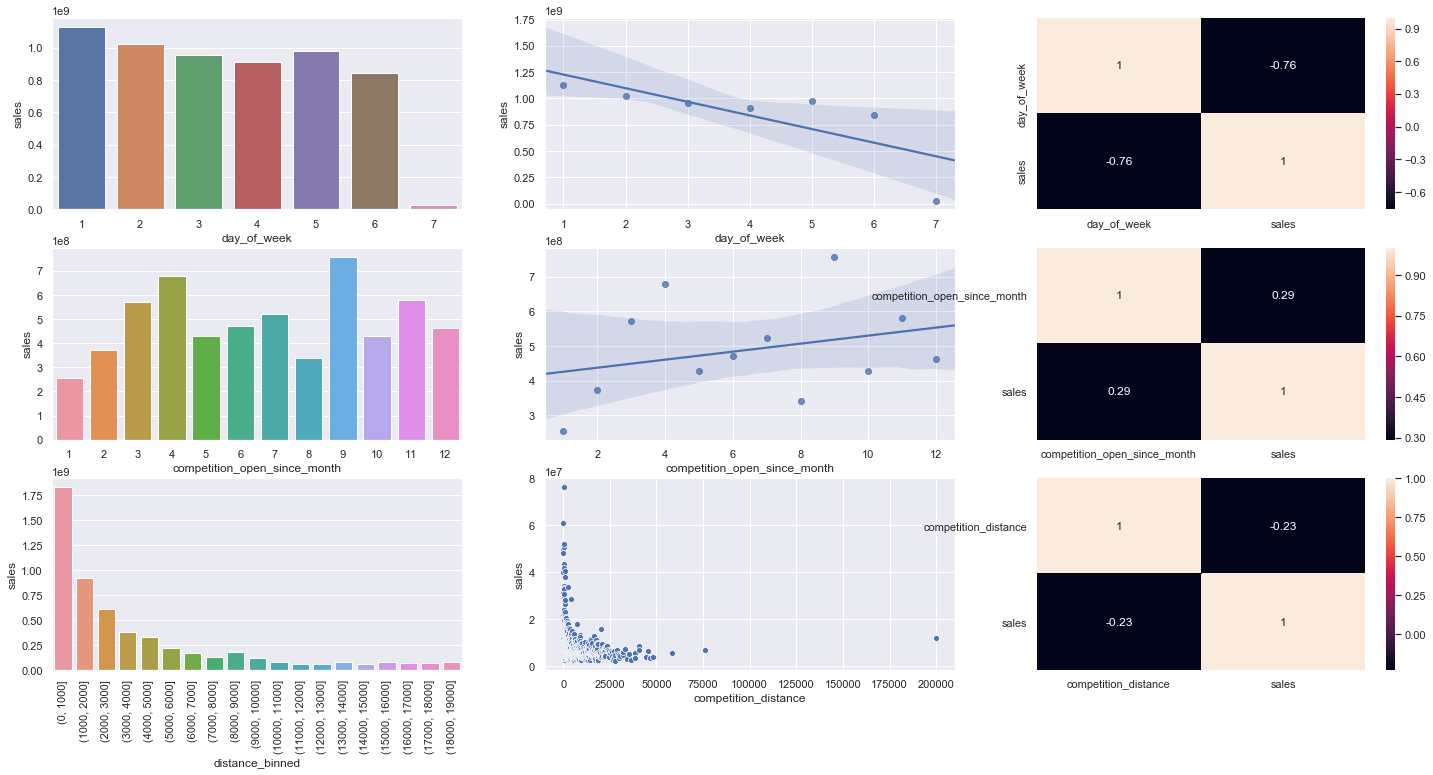

In [41]:
# -------------------
# day of week
# -------------------
aux1 = df5[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# ----------------------------
# competition open since month
# ----------------------------
aux3 = df5[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month' ).sum().reset_index()
cor3 = aux3.corr( method='pearson' )

plt.subplot( 3, 3, 4 )
sns.barplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor3, annot=True )

# -------------------
# competition distance
# -------------------
aux2 = df5[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
cor2 = aux2.corr( method='pearson' )

bins = list( np.arange( 0, 20000, 1000 ) )
aux2['distance_binned'] = pd.cut( aux2['competition_distance'], bins=bins )
aux3 = aux2[['distance_binned', 'sales']].groupby( 'distance_binned' ).sum().reset_index()

plt.subplot( 3, 3, 7 )
sns.barplot( x='distance_binned', y='sales', data=aux3 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 8 )
sns.scatterplot( x='competition_distance', y='sales', data=aux2 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor2, annot=True )


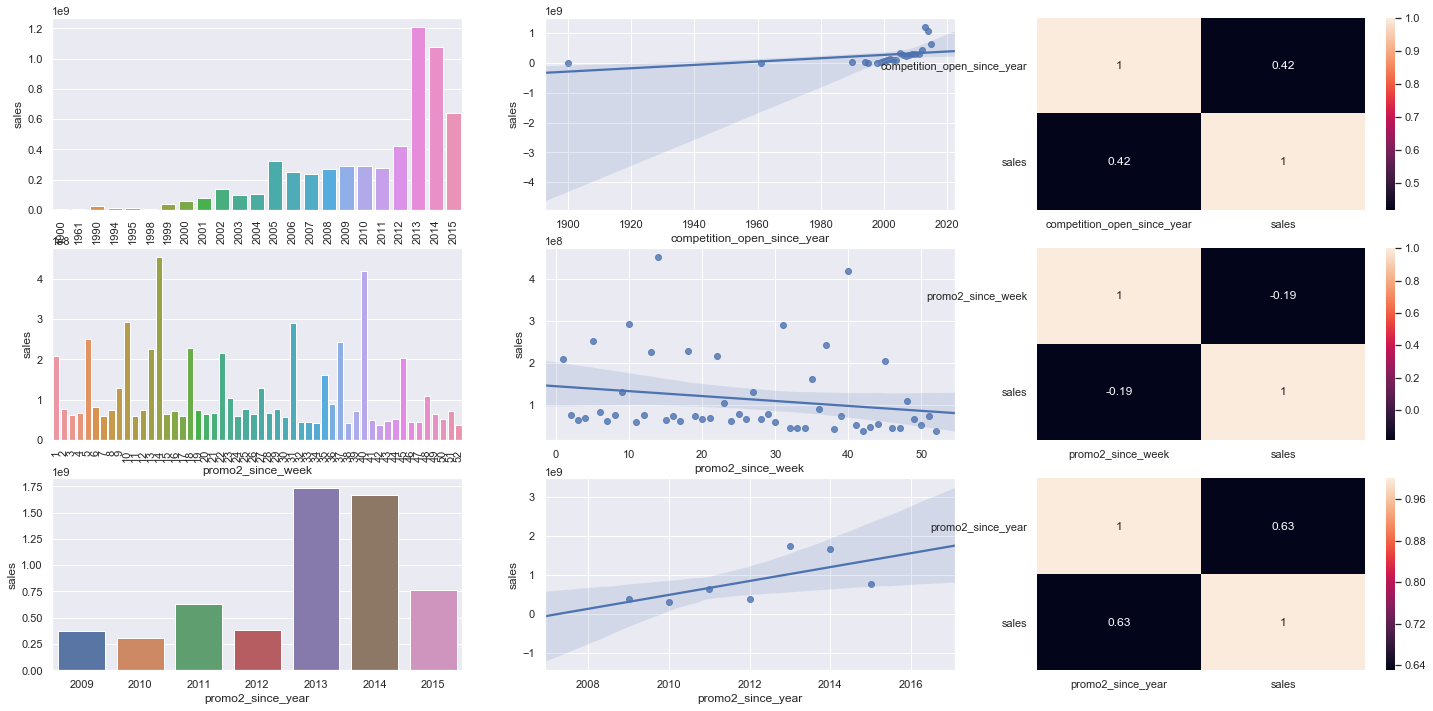

In [42]:
# ----------------------------
# competition open since year
# ----------------------------
aux1 = df5[['competition_open_since_year', 'sales']].groupby( 'competition_open_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='competition_open_since_year', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='competition_open_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since week
# -------------------
aux1 = df5[['promo2_since_week', 'sales']].groupby( 'promo2_since_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='promo2_since_week', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='promo2_since_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since year
# -------------------
aux1 = df5[['promo2_since_year', 'sales']].groupby( 'promo2_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


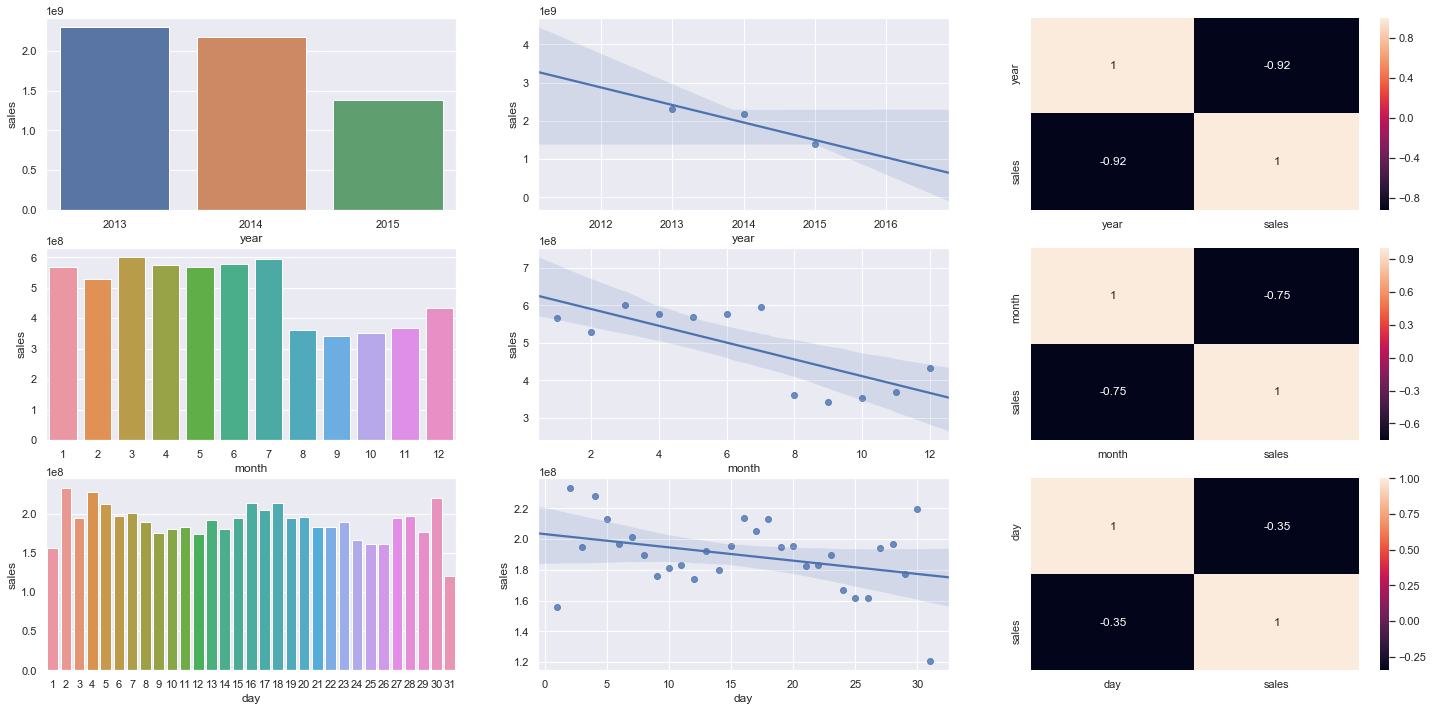

In [43]:
# ----------------------------
# year
# ----------------------------
aux1 = df5[['year', 'sales']].groupby( 'year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month
# -------------------
aux1 = df5[['month', 'sales']].groupby( 'month' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# day
# -------------------
aux1 = df5[['day', 'sales']].groupby( 'day' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


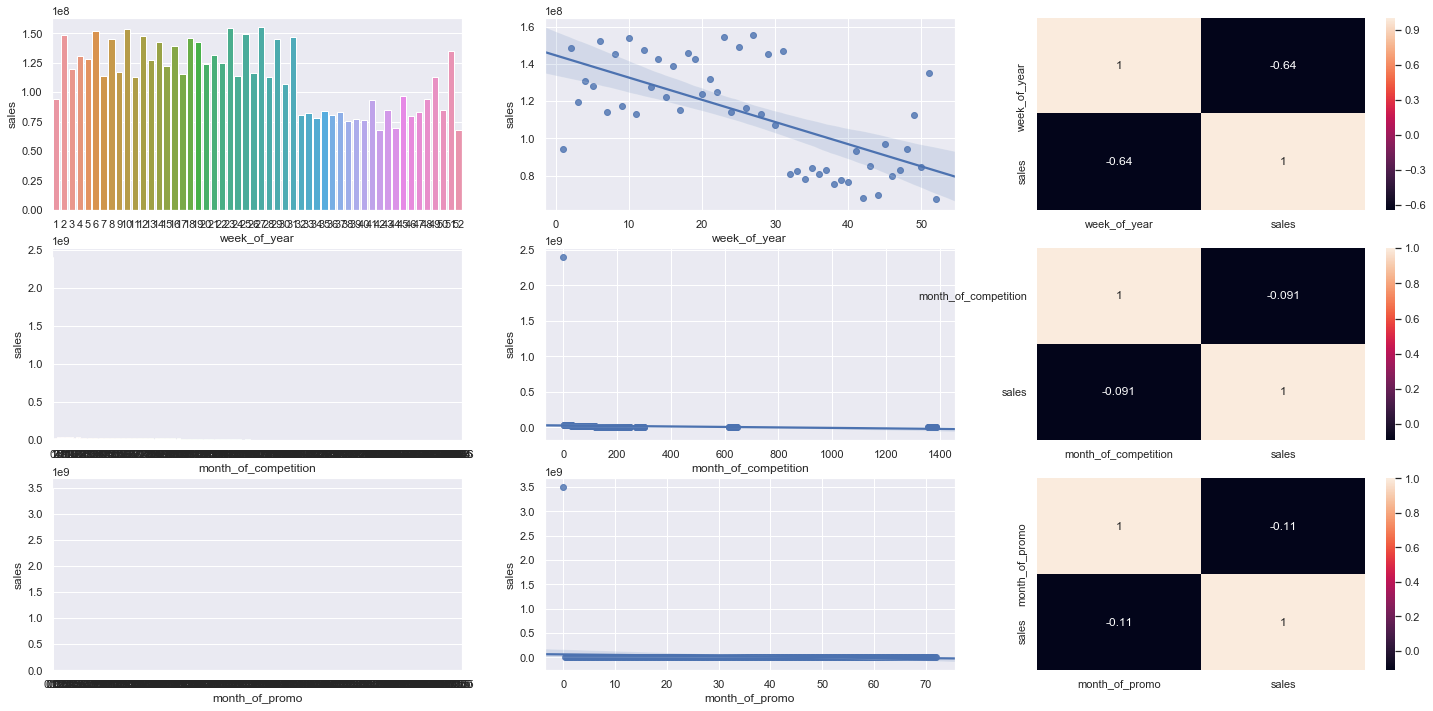

In [44]:
# ----------------------------
# week_of_year
# ----------------------------
aux1 = df5[['week_of_year', 'sales']].groupby( 'week_of_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month of competition
# -------------------
aux1 = df5[['month_of_competition', 'sales']].groupby( 'month_of_competition' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# month_of_promo
# -------------------
aux1 = df5[['month_of_promo', 'sales']].groupby( 'month_of_promo' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )

### 5.2.2. Categorical Predictors

In [45]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


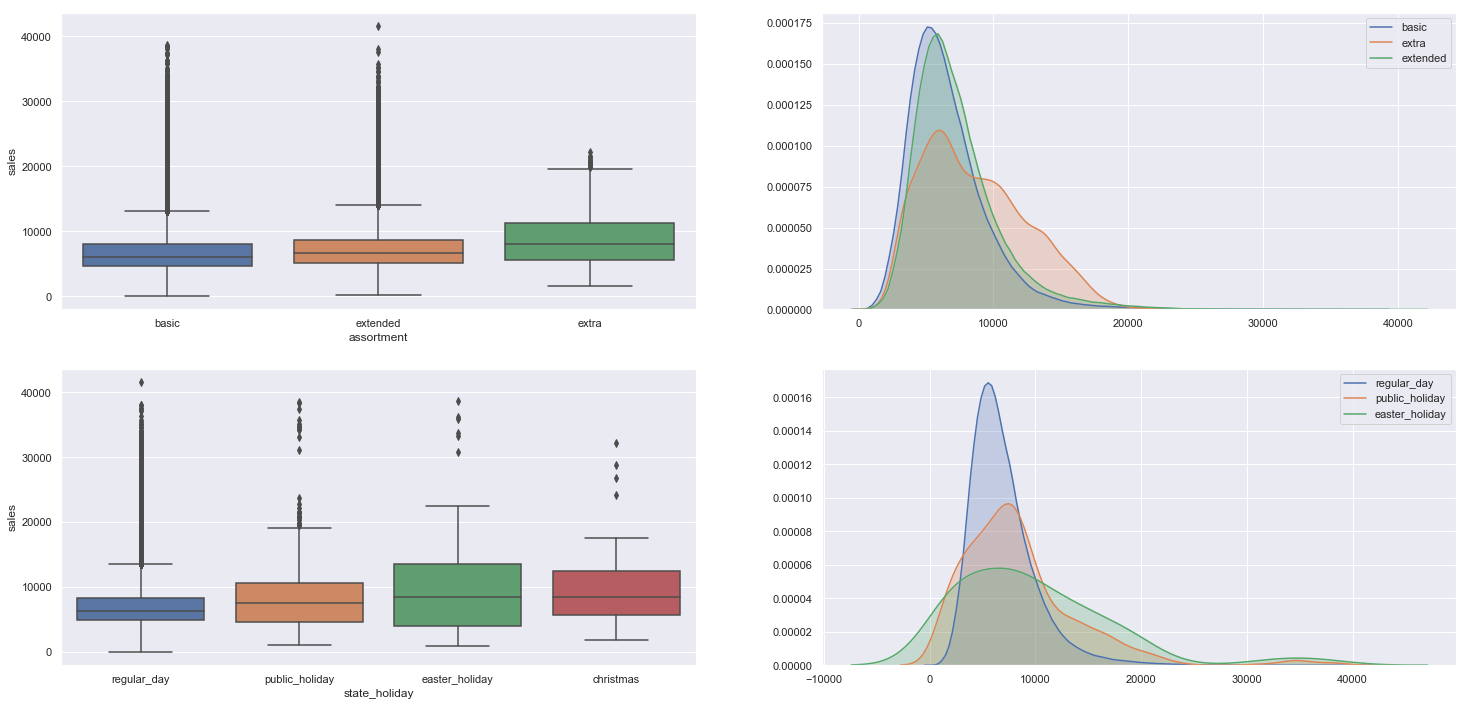

In [46]:
# Assortment X Sales
plt.subplot( 2, 2, 1 )
sns.boxplot( x='assortment', y='sales', data=df5 )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True );

# State Holiday X Sales
plt.subplot( 2, 2, 3 )
sns.boxplot( x='state_holiday', y='sales', data=df5 )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df5[df5['state_holiday'] == 'regular_day']['sales'], label='regular_day', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );

## 5.3. Multivariate Analysis

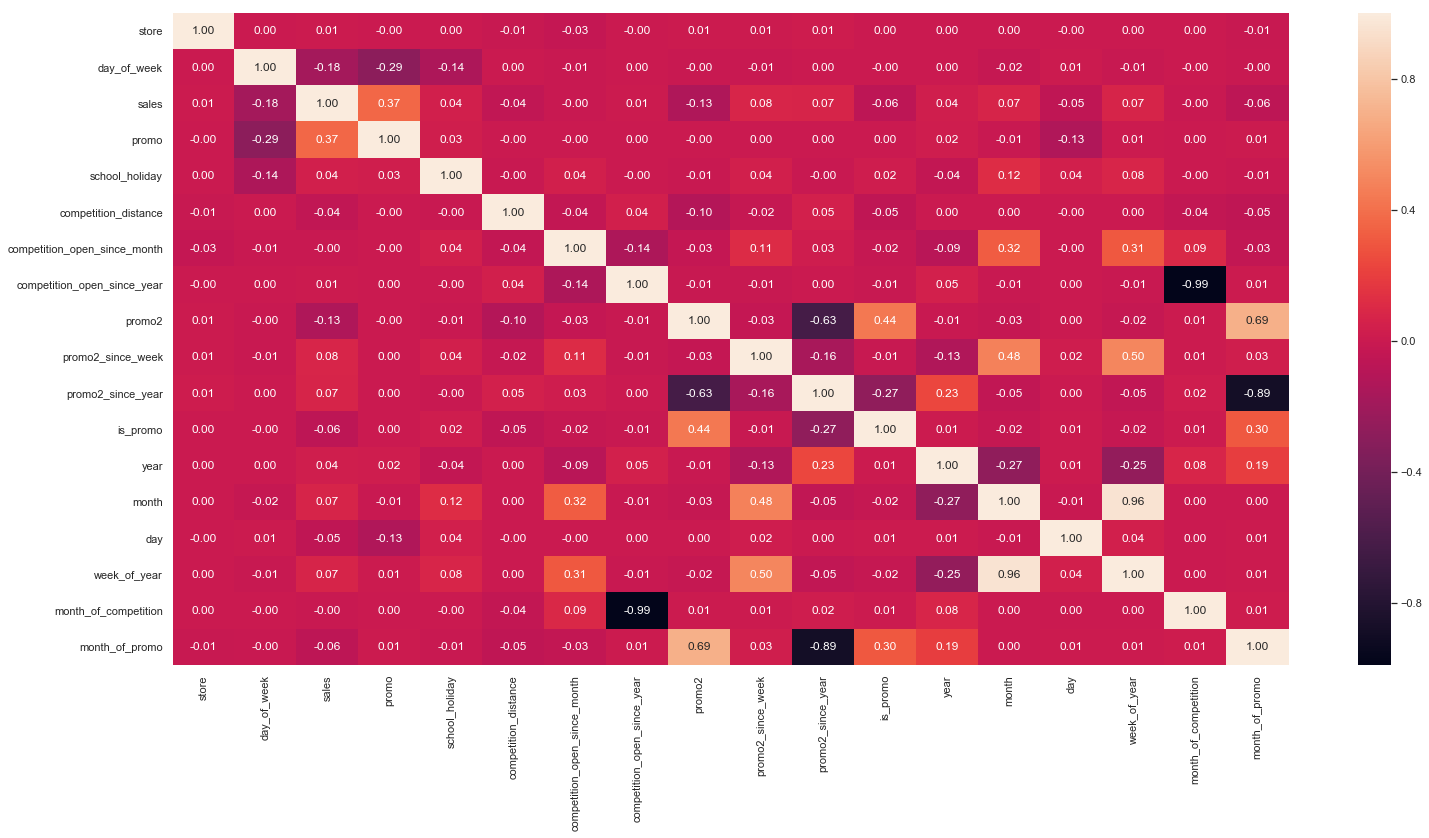

In [47]:
correlation = num_attributes.corr()
sns.heatmap( correlation, annot=True, fmt='.2f' )

plt.show()

# 6.0. DATA PREPARATION
---

In [48]:
df6 = df5.copy()

## 6.1. Numerical Predictors

### 6.1.1. Normalization ( Rescaling )

In [49]:
mms = MinMaxScaler()

In [50]:
# competition distance
df6['competition_distance'] = mms.fit_transform( df6[['competition_distance']].values )
save_parameter_encoder( mms, 'competition_distance', 'minmax' )

# month of promotion
df6['month_of_promo'] = mms.fit_transform( df6[['month_of_promo']].values )
save_parameter_encoder( mms, 'month_of_promo', 'minmax' )

# competition open since year
df6['competition_open_since_year'] = mms.fit_transform( df6[['competition_open_since_year']].values ) 
save_parameter_encoder( mms, 'competition_open_since_year', 'minmax' )

# year
df6['year'] = mms.fit_transform( df6[['year']].values ) 
save_parameter_encoder( mms, 'year', 'minmax' )

# promo2 since year
df6['promo2_since_year'] = mms.fit_transform( df6[['promo2_since_year']].values )
save_parameter_encoder( mms, 'promo2_since_year', 'minmax' )

# month_of_competiton
df6['month_of_competition'] = mms.fit_transform( df6[['month_of_competition']].values )
save_parameter_encoder( mms, 'month_of_competition', 'minmax' )

### 6.1.2. Transformations

In [51]:
# day of week
df6['day_of_week_sin'] = df6['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# competition open since month
df6['competition_open_since_month_sin'] = df6['competition_open_since_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['competition_open_since_month_cos'] = df6['competition_open_since_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# promo 2 since week
df6['promo2_since_week_sin'] = df6['promo2_since_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['promo2_since_week_cos'] = df6['promo2_since_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# month
df6['month_sin'] = df6['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['month_cos'] = df6['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df6['day_sin'] = df6['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
df6['day_cos'] = df6['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['week_of_year_cos'] = df6['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

df6 = df6.drop( ['day_of_week', 'competition_open_since_month', 'promo2_since_week', 'month', 'day', 'week_of_year'], axis=1 )

## 6.2. Categorical Predictors

### 6.2.1. Label Encoding

In [52]:
# Label Encoder
le = LabelEncoder()

# state holiday
df6['state_holiday'] = df6['state_holiday'].apply( lambda x: 1 if x == 'regular_day' else 0 )
df6 = df6.rename( columns={'state_holiday':'regular_day'})

# store_type
df6['store_type'] = le.fit_transform( df6['store_type'] )
save_parameter_encoder( le, 'store_type', 'label_encoder' )

# assortment
df6['assortment'] = le.fit_transform( df6['assortment'] )
save_parameter_encoder( le, 'assortment', 'label_encoder' )

## 6.3. Response Variable

### 6.3.1. Transformations

In [53]:
# Log transformation
df6['sales'] =  np.log1p( df6['sales'] )

In [54]:
df6.sample( 3 )

,store,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,is_promo,year,month_of_competition,month_of_promo,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
100907,558,2015-05-02,8.185907,0,1,0,0,0,0.014901,0.956522,0,1.000000,0,1.0,0.045455,0.000000,-0.781831,0.623490,0.866025,5.000000e-01,0.822984,-0.568065,0.500000,-0.866025,0.394356,0.918958,0.822984,-0.568065
113836,107,2015-04-20,8.871646,0,1,0,0,0,0.009551,0.947826,0,1.000000,0,1.0,0.048341,0.000000,0.781831,0.623490,-1.000000,-1.836970e-16,0.885456,-0.464723,0.866025,-0.500000,-0.790776,-0.612106,0.885456,-0.464723
477450,1016,2014-04-30,9.015298,1,1,0,2,1,0.002650,0.991304,1,0.166667,0,0.5,0.000000,0.607639,0.433884,-0.900969,0.866025,-5.000000e-01,-0.885456,-0.464723,0.866025,-0.500000,-0.201299,0.979530,0.822984,-0.568065


# 7.0. FEATURE SELECTION
---

In [55]:
df7 = df6.copy()

## 7.1. Split training and test dataset

In [56]:
# split the last 6 weeks data as hold-out set
df7 = df7.sort_values( 'date', ascending=False )

## split training and test dataset
# training
X = df7[6*7*1115:]
y = X['sales']

# test
X_test = df7[:6*7*1115]
y_test = X_test['sales']

## 7.2. Boruta Feature Selection

In [ ]:
X_train_n = X.drop( ['sales', 'date'], axis=1 ).values
y_train_n = y.values.ravel()

# define random forest regressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta features selection method
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=1 ).fit( X_train_n, y_train_n )

# selecting features based on the chosen ranking
rank_list = [1]
cols_selected = [ True if x in rank_list else False for x in boruta.ranking_ ]

# select the best features
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# features selected and not selected
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 7.3. Manual Feature Selection

In [57]:
cols_selected_boruta =  ['store', 'store_type', 'assortment', 'promo', 'month_of_promo', 'promo2', 'promo2_since_year', 'promo2_since_week_sin', 'promo2_since_week_cos', 'competition_distance', 
    'competition_open_since_month_sin', 'competition_open_since_month_cos', 'competition_open_since_year', 'month_of_competition', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 
    'month_cos', 'week_of_year_cos']

cols_not_selected_boruta = ['regular_day', 'state_holiday', 'school_holiday', 'is_promo', 'year', 'month_sin', 'week_of_year_sin']

## 7.4. Final Selected Features

In [58]:
# features to delete
feat_to_delete = ['month_cos', 'week_of_year_cos']
feat_to_add = ['date', 'sales']

# features to add
cols_selected_boruta.extend( feat_to_add )

# new columns
new_feat = [ f for f in cols_selected_boruta if f not in feat_to_delete ]


# 8.0. MACHINE LEARNING MODELLING
---

In [95]:
# training and test dataset for cross-validation
X_train = X[ new_feat ]
X_test = X_test[ new_feat ]

# Training and test dataset for training
X_train_n = X_train.drop( ['date', 'sales'], axis=1 )
y_train_n = X_train['sales']

X_test_n = X_test.drop( ['date', 'sales'], axis=1 )
y_test_n = X_test['sales']

# define dates to nested cross-validation
training_start = datetime( 2013, 1, 1 )
training_end = datetime( 2015, 1, 13 )
holdout_end = datetime( 2015, 6, 13 )

# number of folds
k = 10

## 8.1. Average Model ( Baseline Model )

In [112]:
# dataset
aux = X_test.copy()
aux['sales'] = y_test.copy()

# predictions
yhat_store = aux[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux, yhat_store, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance 
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
print( baseline_result )

           Model          MAE      MAPE         RMSE     RMSPE
0  Average Model  1400.295276  0.472481  1878.694596  0.726751


## 8.2. Linear Regression

In [97]:
# model
lr = LinearRegression().fit( X_train_n, y_train_n )

# predictions
yhat_lr = lr.predict( X_test_n )

# performance 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test_n ), np.expm1( yhat_lr ) )
print( lr_result )

               Model          MAE      MAPE         RMSE     RMSPE
0  Linear Regression  1902.030569  0.297662  2700.120445  0.440672


### 8.2.1. Cross Validation

In [124]:
# modelling
lr = LinearRegression()

# nested cross-validation
lr_cv = nested_cross_validation( training_start, training_end, holdout_end, k, X_train, lr, verbose=0 )

lr_avg_rmspe_cv = np.round( lr_cv['AVG RMSPE'], 2 ).astype( str ) + ' +/- ' + np.round( lr_cv['STD RMSPE'], 2 ).astype( str ) 
lr_avg_rmse_cv = np.round( lr_cv['AVG RMSE'], 2 ).astype( str ) + ' +/- ' + np.round( lr_cv['STD RMSE'], 2 ).astype( str )
lr_avg_mae_cv = np.round( lr_cv['AVG MAE'], 2 ).astype( str ) + ' +/- ' + np.round( lr_cv['STD MAE'], 2 ).astype( str )
lr_avg_mape_cv = np.round( lr_cv['AVG MAPE'], 2 ).astype( str ) + ' +/- ' + np.round( lr_cv['STD MAPE'], 2 ).astype( str )

lr_result_cv = pd.DataFrame( {'Model': 'Linear Regression', 'AVG MAE': lr_avg_mae_cv, 'AVG MAPE': lr_avg_mape_cv, 'AVG RMSE': lr_avg_rmse_cv, 'AVG RMSPE': lr_avg_rmspe_cv}, index=[0] )
print( lr_result_cv )

               Model             AVG MAE       AVG MAPE            AVG RMSE      AVG RMSPE
0  Linear Regression  1918.98 +/- 190.52  0.29 +/- 0.01  2718.67 +/- 314.11  0.45 +/- 0.05


## 8.3. Linear Regression Regularized

In [103]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train_n, y_train_n )

# predictions
yhat_lrr = lrr.predict( X_test_n )

# performance 
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test_n ), np.expm1( yhat_lrr ) )
print( lrr_result )

                     Model          MAE      MAPE        RMSE     RMSPE
0  Linear Regression Lasso  1940.105107  0.288984  2821.55795  0.421829


### 8.3.1. Cross Validation

In [125]:
# modeling
lrr = Lasso( alpha=0.01 )

# nested cross-validation
lrr_cv = nested_cross_validation( training_start, training_end, holdout_end, k, X_train, lrr, verbose=0 )

lrr_avg_rmspe_cv = np.round( lrr_cv['AVG RMSPE'], 2 ).astype( str ) + ' +/- ' + np.round( lrr_cv['STD RMSPE'], 2 ).astype( str ) 
lrr_avg_rmse_cv = np.round( lrr_cv['AVG RMSE'], 2 ).astype( str ) + ' +/- ' + np.round( lrr_cv['STD RMSE'], 2 ).astype( str )
lrr_avg_mae_cv = np.round( lrr_cv['AVG MAE'], 2 ).astype( str ) + ' +/- ' + np.round( lrr_cv['STD MAE'], 2 ).astype( str )
lrr_avg_mape_cv = np.round( lrr_cv['AVG MAPE'], 2 ).astype( str ) + ' +/- ' + np.round( lrr_cv['STD MAPE'], 2 ).astype( str )

lrr_result_cv = pd.DataFrame( {'Model': 'Linear Regression', 'AVG MAE': lrr_avg_mae_cv, 'AVG MAPE': lrr_avg_mape_cv, 'AVG RMSE': lrr_avg_rmse_cv, 'AVG RMSPE': lrr_avg_rmspe_cv}, index=[0] )
print( lrr_result_cv )

               Model             AVG MAE       AVG MAPE           AVG RMSE      AVG RMSPE
0  Linear Regression  1956.07 +/- 240.01  0.29 +/- 0.01  2811.4 +/- 373.89  0.44 +/- 0.05


## 8.4. Random Forest Regressor

In [105]:
# model
rf = RandomForestRegressor( n_estimators=10, n_jobs=-1, random_state=0 ).fit( X_train_n, y_train_n )

# predictions
yhat_rf = rf.predict( X_test_n )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test_n ), np.expm1( yhat_rf ) )
print( rf_result )

                     Model         MAE      MAPE         RMSE     RMSPE
0  Random Forest Regressor  781.742133  0.114953  1143.879714  0.160617


### 8.4.1. Cross Validation

In [108]:
# modeling
rf = RandomForestRegressor( n_estimators=10, n_jobs=-1, random_state=0 )

# nested cross-validation
rf_cv = nested_cross_validation( training_start, training_end, holdout_end, k, X_train, rf, verbose=1 )

rf_avg_rmspe_cv = np.round( rf_cv['AVG RMSPE'], 2 ).astype( str ) + ' +/- ' + np.round( rf_cv['STD RMSPE'], 2 ).astype( str ) 
rf_avg_rmse_cv = np.round( rf_cv['AVG RMSE'], 2 ).astype( str ) + ' +/- ' + np.round( rf_cv['STD RMSE'], 2 ).astype( str )
rf_avg_mae_cv = np.round( rf_cv['AVG MAE'], 2 ).astype( str ) + ' +/- ' + np.round( rf_cv['STD MAE'], 2 ).astype( str )
rf_avg_mape_cv = np.round( rf_cv['AVG MAPE'], 2 ).astype( str ) + ' +/- ' + np.round( rf_cv['STD MAPE'], 2 ).astype( str )

rf_result_cv = pd.DataFrame( {'Model': 'Random Forest Regression', 'AVG MAE': rf_avg_mae_cv, 'AVG MAPE': rf_avg_mape_cv, 'AVG RMSE': rf_avg_rmse_cv, 'AVG RMSPE': rf_avg_rmspe_cv}, index=[0] )
print( rf_result_cv )

                     Model     AVG RMSPE            AVG RMSE            AVG MAE
0  Random Forest Regressor  0.2 +/- 0.07  1213.38 +/- 315.73  818.68 +/- 231.04


## 8.5. XGBoost Regressor

### 8.5.1. Training

In [109]:
# model
xgb = xgboost.XGBRegressor( objective='reg:squarederror', n_estimators=10, eta=0.03, max_depth=10, subsample=0.9, colsample_bytree=0.7 ).fit( X_train_n, y_train_n )

# predictions
yhat_xgb = xgb.predict( X_test_n )

# performance
xgb_result = ml_error( 'XGBoost', np.expm1( y_test_n ), np.expm1( yhat_xgb ) )
print( xgb_result )

     Model          MAE      MAPE         RMSE     RMSPE
0  XGBoost  6754.118471  0.941942  7411.813448  0.942141


### 8.5.3. Cross Validation

In [110]:
# model
xgb = xgboost.XGBRegressor( objective='reg:squarederror', n_estimators=10, eta=0.03, max_depth=10, subsample=0.9, colsample_bytree=0.7 )

# modelling cross validation
xgb_cv = nested_cross_validation( training_start, training_end, holdout_end, k, X_train, xgb, verbose=1 )

xgb_avg_rmspe_cv = np.round( xgb_cv['AVG RMSPE'], 2 ).astype( str ) + ' +/- ' + np.round( xgb_cv['STD RMSPE'], 2 ).astype( str ) 
xgb_avg_rmse_cv = np.round( xgb_cv['AVG RMSE'], 2 ).astype( str ) + ' +/- ' + np.round( xgb_cv['STD RMSE'], 2 ).astype( str )
xgb_avg_mae_cv = np.round( xgb_cv['AVG MAE'], 2 ).astype( str ) + ' +/- ' + np.round( xgb_cv['STD MAE'], 2 ).astype( str )
xgb_avg_mape_cv = np.round( xgb_cv['AVG MAPE'], 2 ).astype( str ) + ' +/- ' + np.round( xgb_cv['STD MAE'], 2 ).astype( str )

xgb_result_cv = pd.DataFrame( {'Model': 'XGBoost Regression', 'AVG MAE': xgb_avg_mae_cv, 'AVG MAPE': xgb_avg_mape_cv, 'AVG RMSE': xgb_avg_rmse_cv, 'AVG RMSPE': xgb_avg_rmspe_cv}, index=[0] )

print( xgb_result_cv )

               Model     AVG RMSPE            AVG RMSE             AVG MAE
0  XGBoost Regressor  0.94 +/- 0.0  7326.52 +/- 607.93  6715.57 +/- 538.28


## 8.6. Summary of Modelling

### 8.6.1. Single test dataset

In [114]:
# results
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'MAE' )

,Model,MAE,MAPE,RMSE,RMSPE
0,Random Forest Regressor,781.742133,0.114953,1143.879714,0.160617
0,Average Model,1400.295276,0.472481,1878.694596,0.726751
0,Linear Regression,1902.030569,0.297662,2700.120445,0.440672
0,Linear Regression Lasso,1940.105107,0.288984,2821.557950,0.421829
0,XGBoost,6754.118471,0.941942,7411.813448,0.942141


### 8.6.2. Cross-Validation dataset

In [115]:
# cross validation results
modelling_results_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_results_cv

,Model,AVG RMSPE,AVG RMSE,AVG MAE
0,Linear Regression,0.45 +/- 0.05,2718.67 +/- 314.11,1918.98 +/- 190.52
0,Linear Regression Lasso,0.44 +/- 0.05,2811.4 +/- 373.89,1956.07 +/- 240.01
0,Random Forest Regressor,0.2 +/- 0.07,1213.38 +/- 315.73,818.68 +/- 231.04
0,XGBoost Regressor,0.94 +/- 0.0,7326.52 +/- 607.93,6715.57 +/- 538.28


# 9.0. FINE TUNNING MODELLING
---

## 9.1. Random Search Tunning

In [129]:
# params dictionary
params = {
    'n_estimators': [3, 5, 10],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'eta': [0.1, 0.3],
    'subsample': [0.1, 0.5],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

MAX_EVALS = 2

In [131]:
import random 

# dataframe for results
final_result = pd.DataFrame()
k = 1

# keep searching until reach max evaluations
for i in range( MAX_EVALS ):
    # choose random hyperparameters
    hp = {k: random.sample( v, 1)[0] for k, v in params.items() }
    print( hp )
    
    # model
    xgb = xgboost.XGBRegressor( objective = 'reg:squarederror', 
                                n_estimators = hp['n_estimators'], 
                                eta = hp['eta'], 
                                max_depth = hp['max_depth'], 
                                subsample = hp['subsample'],
                                min_child_weight = hp['min_child_weight'],
                                colsample_bytree = hp['colsample_bytree'] )

    # Evaluate randomly selected hyperparameters
    eval_result = nested_cross_validation( training_start, training_end, holdout_end, k, X_train, xgb, verbose=1 )
    
    # results
    aux1 = pd.DataFrame( eval_result, index=[0] )
    aux2 = pd.DataFrame( hp, index=[0] )
    aux3 = pd.concat( [aux1, aux2 ], axis=1 )
    
    final_result = pd.concat( [final_result, aux3], axis=0 )
    
final_result.sort_values( 'AVG MAE' )

{'n_estimators': 5, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.3, 'subsample': 0.5, 'colsample_bytree': 0.8}
Fold K: 1
{'n_estimators': 3, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.1, 'subsample': 0.1, 'colsample_bytree': 1.0}
Fold K: 1


,AVG MAE,STD MAE,AVG MAPE,STD MAPE,AVG RMSE,STD RMSE,AVG RMSPE,STD RMSPE,n_estimators,max_depth,min_child_weight,eta,subsample,colsample_bytree
0,7002.013936,0.0,0.992154,0.0,7621.742976,0.0,0.992160,0.0,5,5,5,0.3,0.5,0.8
0,7035.168261,0.0,0.997603,0.0,7652.860905,0.0,0.997604,0.0,3,5,5,0.1,0.1,1.0


## 9.2. Final Model Tunning

In [ ]:
# final model
xgb_tunned = xgboost.XGBRegressor( objective='reg:squarederror', 
                                   n_estimators=param_tunned['n_estimators'], 
                                   eta=param_tunned['eta'], 
                                   max_depth=param_tunned['max_depth'], 
                                   max_child_weight=param_tunned['min_child_weight'],
                                   subsample=param_tunned['subsample'], 
                                   colsample_bytree=param_tunned['colsample_bytree'] ).fit( X_train_n, y_train_n )

# predictions
yhat_xgb_tunned = xgb_tunned.predict( X_test_n )

# performance
xgb_result_tunned = ml_error( 'XGBoost', np.expm1( y_test_n ), np.expm1( yhat_xgb_tunned ) )
print( xgb_result_tunned )

# 10.0. ERROR INTEPRETATION
---

In [404]:
df10 = X_test.copy()

In [405]:
# add the predictions
df10['predictions'] = yhat_xgb_tunned

# Transform response variables back to original scale
df10['sales'] = np.expm1( df10['sales'] )
df10['predictions'] = np.round( np.expm1( df10['predictions'] ) )

# compute the error
df10['error'] = df10['sales'] - df10['predictions']
df10['error_type'] = df10['error'].apply( lambda x: 'underestimate' if x > 0 else 'overestimate' )
df10['error_ratio'] = df10['predictions']/df10['sales'] 

## compute the error by store
#aux = df10[['store', 'sales', 'predictions']].groupby( 'store' ).sum().reset_index()
#aux['mape'] = aux.apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )

## 10.1. Model Performance

In [407]:
#a = df10[df10['store'] == 255][['date', 'sales', 'predictions', 'error', 'error_ratio', 'error_type']]

In [412]:
sales_total = np.round( np.sum( df10['sales'] ) )
pred_total = np.round( np.sum( df10['predictions'] ) )

sales_avg = np.round( np.mean( df10['sales'] ) )
sales_std = np.round( np.std( df10['sales'] ) )
sales_min = np.round( np.min( df10['sales'] ) )
sales_max = np.round( np.max( df10['sales'] ) )

mape = mean_absolute_percentage_error( df10['sales'], df10['predictions'] )
mpe = mean_percentage_error( df10['sales'], df10['predictions'])
mae = np.round( mean_absolute_error( df10['sales'], df10['predictions'] ), 2 )

print( 'Total Sales: {}'.format( sales_total ) )
print( 'Avg Sales: {} +/- {}'.format( sales_avg, sales_std ) )
print( 'Min: {}, Max:{}'.format( sales_min, sales_max ) )

print( '\nMAE: {}'.format( mae ) )
print( 'MAPE: {:.2f}%'.format( mape ) )
print( 'MPE: {:.2f}%'.format( mpe ) )

Total Sales: 333365121.0
Avg Sales: 7119.0 +/- 3092.0
Min: 569.0, Max:41551.0

MAE: 694.71
MAPE: 10.36%
MPE: -2.89%


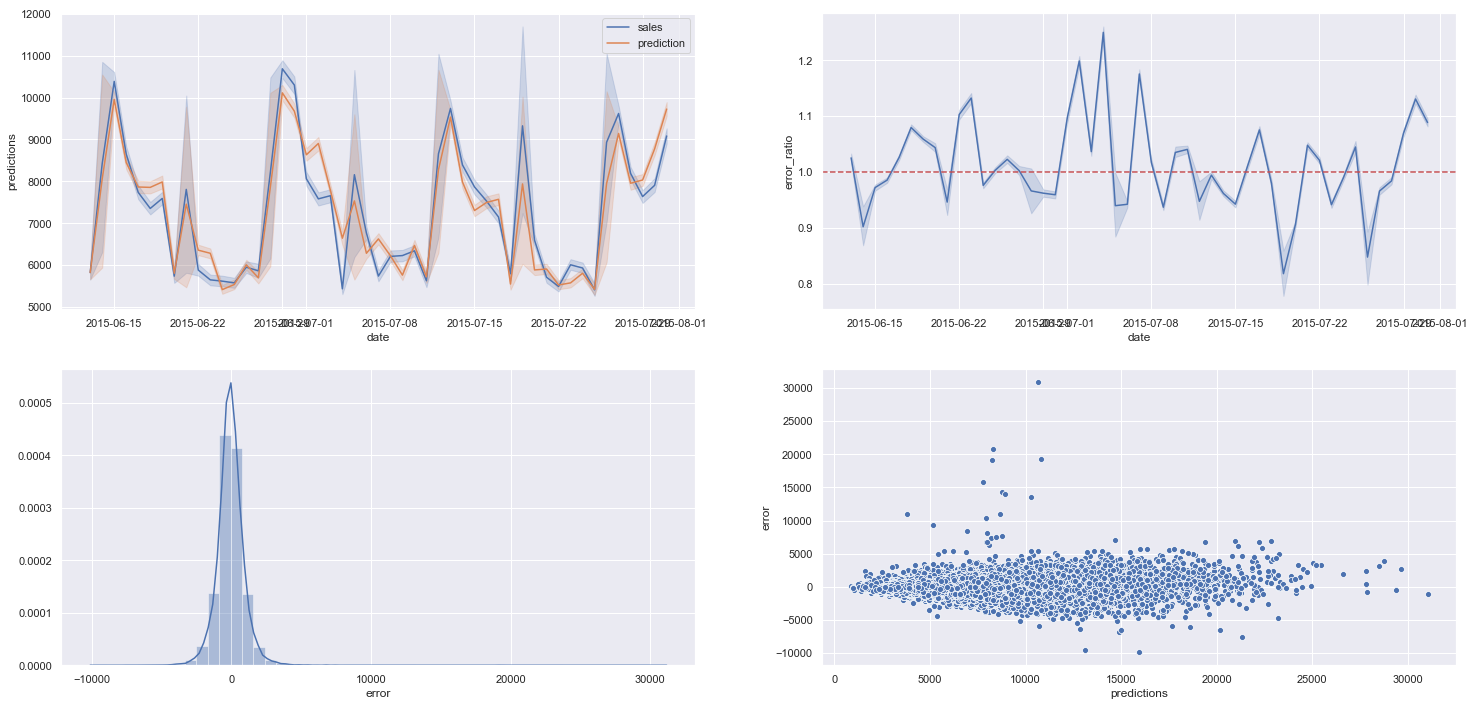

In [414]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df10, label='sales' )
sns.lineplot( x='date', y='predictions', data=df10, label='prediction' )
plt.legend()

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_ratio', data=df10 )
plt.axhline( 1, color='r', linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df10['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df10['predictions'], df10['error'] )

## 10.2. Business Performance

In [415]:
sales_total = np.round( df10['sales'].sum() )
pred_total = df10['predictions'].sum()

acc = 100*( 1 - ( ( sales_total - pred_total )/sales_total ) )

print( 'Total Sales in 6 weeks: {}'.format( sales_total ) )
print( 'Total Prediction in 6 weeks: {}'.format( pred_total ) )
print( 'ACC: {0:.2f}%'.format( acc ) )

Total Sales in 6 weeks: 333365121.0
Total Prediction in 6 weeks: 336080736.0
ACC: 100.81%


# 11.0. MODEL TO PRODUCTION
---

In [75]:
df11 = df7[ new_feat ]

In [79]:
# full training data
X_train_full = df11.drop( ['date', 'sales'], axis=1 )
y_train_full = df11['sales']

## 11.1. XGBoost training

In [ ]:
# final model
xgb = xgboost.XGBRegressor( objective='reg:squarederror', 
                            n_estimators=param_tunned['n_estimators'], 
                            eta=param_tunned['eta'], 
                            max_depth=param_tunned['max_depth'], 
                            max_child_weight=param_tunned['min_child_weight'],
                            subsample=param_tunned['subsample'], 
                            colsample_bytree=param_tunned['colsample_bytree'] )

# training
xgb_tunned = xgb.fit( X_train_full, y_train_full )

## 11.2. Save Trained Model

In [145]:
# save the trained model
pickle.dump( xgb_tunned, open( '/Users/meigarom/repos/Predictive-Analytics/model/model_{}.pkl'.format( 'xgb' ), 'wb' ) )

# 12.0. MAKE PREDICTION
---

## 12.2. Multiple Examples

In [630]:
test_raw = pd.read_csv( '../data/test.csv' )

# Merge dataset
df_test = pd.merge( test_raw, df_stores_raw, on='Store', how='left' )

# remove close days and undefined days
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test[df_test['Open'] != 0]

### 12.2.1. Transform Method from Class

In [356]:
#df1 = df_test.copy()
#
## new columns name
#new_cols=['id', 'store', 'day_of_week', 'date', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
#          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']
#
## rename
#df1.columns = new_cols
#
## convert to datetime
#df1['date'] = pd.to_datetime( df1['date'] )
#
## --------------------
## ----- Treat NA -----
## --------------------
#
## promo2_since_year
#df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
#
## promo2_since_week
#df1['promo2_since_week'] = df1.apply( lambda x: x['date'].weekofyear if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
#
## competition_distance
#df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
#
## competition_open_since_month
#df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 
#
## competition_open_since_year
#df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
#
## promo_interval
### fill na with 0
#df1.fillna( 0, inplace=True )
## if date is in the promo interval, there is promo.
#monthmap = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
#df1['month_map'] = df1['date'].dt.month.map( monthmap )
#df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
#
## ----------------------------
## ----- Change Data Type -----
## ----------------------------
## change competition data - Month and Year
#df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
#df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
#
## change competition data - Week
#df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
#df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
#
## ----------------------------
## ----- Create Features -----
## ----------------------------
## year
#df1['year'] = df1['date'].dt.year
#
## month
#df1['month'] = df1['date'].dt.month
#
## day
#df1['day'] = df1['date'].dt.day
#
## week of year
#df1['week_of_year'] = df1['date'].dt.weekofyear
#
## state_holiday
#df1['state_holiday'] = df1['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 
#
## assortment
#df1['assortment'] = df1['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#
## competition weeks
#df1['month_of_competition'] = 12*( df1['year'] - df1['competition_open_since_year'] ) + ( df1['month'] - df1['competition_open_since_month'] )
#df1['month_of_competition'] = df1['month_of_competition'].apply( lambda x: x if x > 0 else 0 )
#
## promomotion weeks
#df1['month_of_promo'] = 12*( df1['year'] - df1['promo2_since_year'] ) + ( df1['week_of_year'] - df1['promo2_since_week'] )/4
#df1['month_of_promo'] = df1['month_of_promo'].apply( lambda x: x if x > 0 else 0 )
#
## ----------------------------
## ------ Filtering Data ------
## ----------------------------
#df1 = df1[df1['open'] != 0]
#
## drop columns
#df1 = df1.drop( ['id', 'date', 'open', 'state_holiday', 'school_holiday', 'is_promo', 'year', 'month', 'week_of_year', 'promo_interval', 'month_map'], axis=1 )

In [631]:
# data
b = df_test.to_dict( orient='records' )
d = json.dumps( b )

# prediction request
h = {'Content-type': 'application/json'}
r = requests.post( 'http://0.0.0.0:5000/rossmann/predict', data=d, headers=h )
print( 'Request Status: {} code:{}'.format( r.status_code, r.status_code ) )
    
# results 
df_results = pd.DataFrame( r.json(), columns=list( r.json()[0].keys() ) )

Request Status: 200 code:200


In [632]:
df_results.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Prediction
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None,4216.598145
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7888.872559
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,None,8698.427734
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,None,7359.765625
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,None,6970.246094


## 12.3. Final Results

In [633]:
store_sales = df_results[['Store', 'Prediction']].groupby( 'Store' ).sum().reset_index()

In [643]:
for i in range( 0, len( store_sales ) ):
    print( 'Store {} will sell ${:,.2f} in the next 6 weeks'.format( store_sales.loc[i, 'Store'], store_sales.loc[i, 'Prediction'] ) )

Store 1 will sell $177,688.94 in the next 6 weeks
Store 3 will sell $251,289.75 in the next 6 weeks
Store 7 will sell $403,800.62 in the next 6 weeks
Store 8 will sell $251,769.56 in the next 6 weeks
Store 9 will sell $293,656.28 in the next 6 weeks
Store 10 will sell $229,867.94 in the next 6 weeks
Store 11 will sell $255,207.95 in the next 6 weeks
Store 12 will sell $281,809.86 in the next 6 weeks
Store 13 will sell $198,991.36 in the next 6 weeks
Store 14 will sell $202,297.86 in the next 6 weeks
Store 15 will sell $226,303.34 in the next 6 weeks
Store 16 will sell $307,704.43 in the next 6 weeks
Store 19 will sell $235,682.06 in the next 6 weeks
Store 20 will sell $317,592.62 in the next 6 weeks
Store 21 will sell $221,324.10 in the next 6 weeks
Store 22 will sell $183,613.36 in the next 6 weeks
Store 23 will sell $222,288.77 in the next 6 weeks
Store 24 will sell $340,626.48 in the next 6 weeks
Store 25 will sell $409,411.51 in the next 6 weeks
Store 27 will sell $335,802.82 in th

# 20. REFERENCES
---

## 20.0. Rossmann Store Competition

1. https://www.kaggle.com/hely333/eda-regression
2. http://rstudio-pubs-static.s3.amazonaws.com/142772_218508e3f94e4419944e9104505b6f17.html
3. http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/
4. https://www.kaggle.com/c/rossmann-store-sales/discussion/17974
5. https://jikeme.com/rossmann-store-sales-winners-interview-3rd-place-neokami-inc
6. https://github.com/li-kai/rossman-store-sales/blob/master/hw3-rossman.ipynb
7. http://blog.kaggle.com/2015/12/21/rossmann-store-sales-winners-interview-1st-place-gert/
8. http://cs229.stanford.edu/proj2015/218_report.pdf
9. http://rohanrao91.blogspot.com/2015/12/rossmann-store-sales.html
10. https://mabrek.github.io/blog/kaggle-forecasting/
11. https://arxiv.org/pdf/1604.06737.pdf
12. http://www.johnatate.com/learning-from-the-best-rossman-sales-kaggle-winners.html
13. https://www.kaggle.com/abhilashawasthi/xgb-rossmann
14. https://www.kaggle.com/c/rossmann-store-sales/discussion/18024
15. https://rpubs.com/gpetho/142772
16. http://www.3leafnodes.com/random-forest-regression-train-with-one-feature-grid-search
17. https://github.com/Semantive/Kaggle-Demand-Forecasting-Models

## 20.1. Encoding Cyclical Values

1. https://www.avanwyk.com/encoding-cyclical-features-for-deep-learning/
2. https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
3. https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
4. http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

## 20.2. XGBoost Fine Tunning

1. https://stackoverflow.com/questions/37583263/scikit-learn-cross-validation-custom-splits-for-time-series-data
2. https://datascience-enthusiast.com/R/ML_python_R_part2.html
3. https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
4. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
5. https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
6. https://www.kaggle.com/general/17120
7. https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
8. https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression 

1. http://krasserm.github.io/2018/03/21/bayesian-optimization/

## 20.3. Bayesian Optimization

1. http://krasserm.github.io/2018/03/21/bayesian-optimization/

## 20.4. Public Dataset

1. https://www.kaggle.com/marcinex1423/salesdb-grocery#salesDB_grocery_market.zip
1. https://www.kaggle.com/fayomi/advertising
2. https://www.kaggle.com/harlfoxem/housesalesprediction
3. https://github.com/awesomedata/awesome-public-datasets
4. https://www.kdnuggets.com/datasets/index.html
5. https://www.kaggle.com/devashish0507/big-mart-sales-prediction
6. https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

## 20.5. Time Series Courses

1. https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
2. https://www.kaggle.com/devilears/siraj-s-steps-lstm
3.

## 20.6. Feature Selection

1. http://dkopczyk.quantee.co.uk/feature-selection/
2. https://towardsdatascience.com/the-hitchhikers-guide-to-feature-extraction-b4c157e96631

## 20.7. Data Exploration

1. https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

## 20.8. Prediction Interval

1. https://blog.datadive.net/prediction-intervals-for-random-forests/
2. https://stats.stackexchange.com/questions/16493/difference-between-confidence-intervals-and-prediction-intervals/16496#16496
3. https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b

## 20.9. Cross Validation Folds by Index

In [ ]:
# define dates to nested cross-validation
training_start = datetime( 2013, 1, 1 )
training_end = datetime( 2015, 1, 13 )
holdout_end = datetime( 2015, 6, 13 )

# number of folds
kfold = 10

# how many days between training end and holdout end
n_day = np.round( ( holdout_end - training_end ).days / kfold )

# K fold cross validation
cv_folder = []
for i in range( 1, kfold + 1 ):
    # training
    fold_training_start = training_start
    fold_training_end = training_end + timedelta( days=( i - 1 )*n_day )

    # valid
    fold_valid_start = fold_training_end
    fold_valid_end = fold_valid_start + timedelta( days=( n_day ) )
    
    # model training with k fold
    x_train = X_train[(X_train['date'] >= fold_training_start) & (X_train['date'] <= fold_training_end)]
    
    if i == kfold:
        x_valid = X_train[(X_train['date'] > fold_valid_start) & (X_train['date'] <= holdout_end)]
    else:
        x_valid = X_train[(X_train['date'] > fold_valid_start) & (X_train['date'] <= fold_valid_end)]
    
    # get the index of the training and valid into a list
    train_list = x_train.index.values.tolist()
    valid_list = x_valid.index.values.tolist()
    
    print( i )
    print( 'min train date:{} index:{}'.format( np.min( x_train['date'] ) , np.min( x_train.index.values ) ) ) 
    print( 'max train date:{} index:{}'.format( np.max( x_train['date'] ) , np.max( x_train.index.values ) ) ) 
    
    print( 'min valid date:{} index:{}'.format( np.min( x_valid['date'] ) , np.min( x_valid.index.values ) ) ) 
    print( 'max valid date:{} index:{}'.format( np.max( x_valid['date'] ) , np.max( x_valid.index.values ) ) ) 
    
    aux = (valid_list, valid_list)
    cv_folder.append( aux )

    if i > 1:
        cv_results = xgb.cv( params, dtrain, num_boost_round=999, seed=42, nfold=len(cv_folder), folds=cv_folder, metrics={'mae'}, early_stopping_rounds=10 )